# Predicting defaulting on credit card applications

When customers come in financial difficulties, it usually does not happen at once. There are indicators which can be used to anticipate the final outcome, such as late payments, calls to the customer services, enquiries about the products, a different browsing pattern on the web or mobile app. By using such patterns it is possible to prevent, or at least guide the process and provide a better service for the customer as well as reduced risks for the bank.

In this tutorial we will look at how to predict defaulting, using statistics, machine learning and deep learning. We we also look at how to summarize the data using topological data analysis (TDA). Finally we will look at how to APIfy the model and use it for account alerting.

### Synopysis

This notebook unfolds in the following phases

  - Getting the Data
  - Data Preparation
  - Descriptive analytics
  - Feature Engineering
  - Dimensionality Reduction
  - Modeling
  - Explainability
  
### Modeling
  
I will compare the predictive power of four bespoken classes of algorithms
  
  - Logistic regression (scikit-learn)
  - Random Forests (scikit-learn)
  - Boosted Trees (xgboost)
  - Deep Learning (keras/tensorflow)
    
### Interpretability and Explainability

Understanding why a given model predicts the way it predicts, it probably just as important as achieving a good accuracy on the predicted results. I will present 3 methods which can be used to interpret and explain the result and gain a better understanding on the dataset and the various.

  - Extract activations from an inner layer of a neural network
  - Apply TSNE on the activation data
  - OPTICS for variable density clustering
  - TDA with a Kepler Mapper using the TSNE lens

### Source

The dataset is availble at the Center for Machine Learning and Intelligent Systems, Bren School of Information and Computer Science, University of California, Irvine: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

Citation:  
Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.

The dataset Name: I-Cheng Yeh 
email addresses: (1) icyeh '@' chu.edu.tw (2) 140910 '@' mail.tku.edu.tw  
institutions: (1) Department of Information Management, Chung Hua University, Taiwan. (2) Department of Civil Engineering, Tamkang University, Taiwan. other contact information: 886-2-26215656 ext. 3181 

Extract from the [dataset information section][1] :
"This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients."

[1]:[https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients]

#### Imports

In [1]:
#data import
import wget
import urllib

# regex
import re

#time
import pytz as tz
from datetime import datetime

#data explore
import numpy as np
np.random.seed(1337)

#support for reading excel files
import xlrd

# dataframes in python
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

#defaults
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 10})
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'

plt.style.use('ggplot')

#### Data preparation
We cache the data set from the above mentioned repository in a local directory. 

In [3]:
import os
import shutil

datadir = './data'
if not os.path.exists(datadir):
    os.makedirs(datadir)

In [4]:
# Get the dataset from UCI

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default of credit card clients.xls' 
filename = os.path.join(datadir, 'default of credit card clients.xls')

if not os.path.isfile(filename):
    wget.download(url, out=filename)

#### Convert the data
We use pandas to read the data from its original excel format into a dataframe

In [5]:
df = pd.read_excel(filename, header=1)

#### Clean up
We lowercase the column name, and rename the column names when required,
In particular, remarkably this dataset misses a colum `PAY_1`. In the analysis here below we assume that PAY_0 is actually pay_1, to be consider the repayment of the month prior to the month where we calculate the defaulting (which is October 2005, in this particular dataset)

In [6]:
df.columns = [x.lower() for x in df.columns]
df = df.rename(index=str, columns={"pay_0": "pay_1"})
df = df.drop('id', axis=1)
df.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default payment next month'],
      dtype='object')

In [7]:
print("Explanatory variables:  {}".format(len(df.columns)-1))
print("Number of Observations: {}".format(df.shape[0]))

df['target'] = df['default payment next month'].astype('category')

# create a 'target' column for our own convenience
print("Target variable:       '{}' -> '{}'".format('default payment next month', 'target'))


Explanatory variables:  23
Number of Observations: 30000
Target variable:       'default payment next month' -> 'target'


#### Attributes description
This study uses 23 variables as explanatory variables, extracted/interpreted from : 
    
```
   ----------------------------------------------------------------------------------------
   Name                 Explantion        
   -------------------- -------------------------------------------------------------------
   limit_bal            Amount of the given credit (NT dollar): 
                        it includes both the individual consumer credit 
                        and his/her family (supplementary) credit.
   
   sex                  Gender 
                        (1 = male; 2 = female)
   
   education            Education
                        (1 = graduate school; 2 = university; 3 = high school; 4 = others)
   
   marriage             Marital status 
                        (1 = married; 2 = single; 3 = others)
   
   age                  Age (years)
   
   pay_1 - pay_6        History of past payment. Past monthly payment records 
                        From April to September, 2005 as follows:
                        
                        pay_1 = the repayment status in September, 2005
                        pay_2 = the repayment status in August, 2005
                        ...
                        pay_6 = the repayment status in April, 2005 
                        
                        The measurement scale for the repayment status is: 
                        -1 = pay duly; 
                        1 = payment delay for one month 
                        2 = payment delay for two months
                        ...
                        8 = payment delay for eight months 
                        9 = payment delay for nine months and above
                        
   bill_amt1-bill_amt5  Amount of bill statement (NT dollar). 
                        bill_amt1 = amount of bill statement in September, 2005 
                        bill_amt2 = amount of bill statement in August, 2005
                        ...
                        bill_amt6= amount of bill statement in April, 2005 
                        
   pay_amt1-pay_amt6    Amount of previous payment (NT dollar)
                        pay_amt1 = amount paid in September, 2005
                        pay_amt2 = amount paid in August, 2005
                        ...
                        pay_amt6 = amount paid in April, 2005 
   ----------------------------------------------------------------------------------------
```


#### Descriptive Analytics

##### Payment Delays
Let's start by looking at the past payment delays

In [8]:
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]

df[pay_status_columns].head(10)

,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6
0,2,2,-1,-1,-2,-2
1,-1,2,0,0,0,2
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,-1,0,-1,0,0,0
5,0,0,0,0,0,0
6,0,0,0,0,0,0
7,0,-1,-1,0,0,-1
8,0,0,2,0,0,0
9,-2,-2,-2,-2,-1,-1


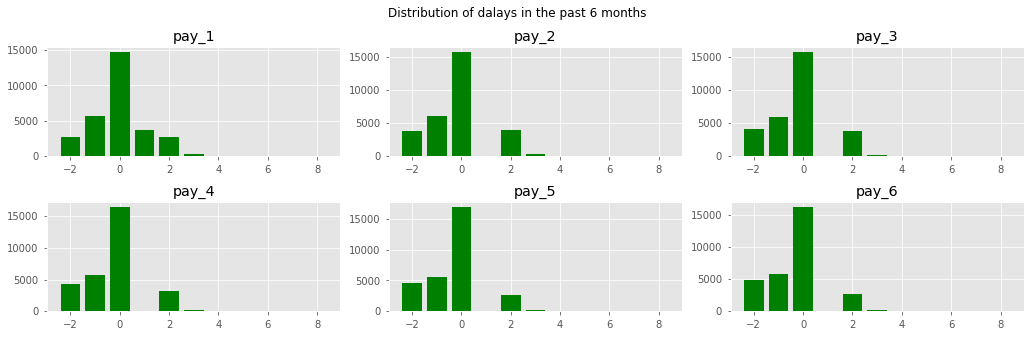

In [9]:
# pay status columns
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]

fig, ax = plt.subplots(2,3)
fig.set_size_inches(15,5)
fig.suptitle('Distribution of dalays in the past 6 months')

for i in range(len(pay_status_columns)):
    row,col = int(i/3), i%3

    d  = df[pay_status_columns[i]].value_counts()
    ax[row,col].bar(d.index, d, align='center', color='g')
    ax[row,col].set_title(pay_status_columns[i])

plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
plt.show()

As you can see some people pay 2 month upfront, others one month upfront, most of them are on par. a few are running behind payments. One thing worth of notice is that the textual information provided about this variables and the actual values are not extactly the same. So always look and explore the data, before proceeding with any analysis, explore and verify the actual data and the textual info about the data itself.

##### Standing credit
Let's look now at how the debts/credit is accumulating over the months, credit to be repaid is a positive number here.

In [10]:
# bill columns
pattern = re.compile("^bill_amt[0-9]+$")
bill_columns = [ x for x in df.columns if (pattern.match(x))]
df[bill_columns].describe()

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


In [11]:
df[bill_columns].head(10)

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6
0,3913,3102,689,0,0,0
1,2682,1725,2682,3272,3455,3261
2,29239,14027,13559,14331,14948,15549
3,46990,48233,49291,28314,28959,29547
4,8617,5670,35835,20940,19146,19131
5,64400,57069,57608,19394,19619,20024
6,367965,412023,445007,542653,483003,473944
7,11876,380,601,221,-159,567
8,11285,14096,12108,12211,11793,3719
9,0,0,0,0,13007,13912


##### Payments in the previous months
Let's have a quick look at how the payments are performed in the previous month.

In [12]:
# pay status columns
pattern = re.compile("^pay_amt[0-9]+$")
pay_amount_columns = [ x for x in df.columns if (pattern.match(x))]
df[pay_amount_columns].describe()

,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [13]:
df[pay_amount_columns].head(10)

,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
0,0,689,0,0,0,0
1,0,1000,1000,1000,0,2000
2,1518,1500,1000,1000,1000,5000
3,2000,2019,1200,1100,1069,1000
4,2000,36681,10000,9000,689,679
5,2500,1815,657,1000,1000,800
6,55000,40000,38000,20239,13750,13770
7,380,601,0,581,1687,1542
8,3329,0,432,1000,1000,1000
9,0,0,0,13007,1122,0


In [14]:
df['limit_bal'].describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: limit_bal, dtype: float64

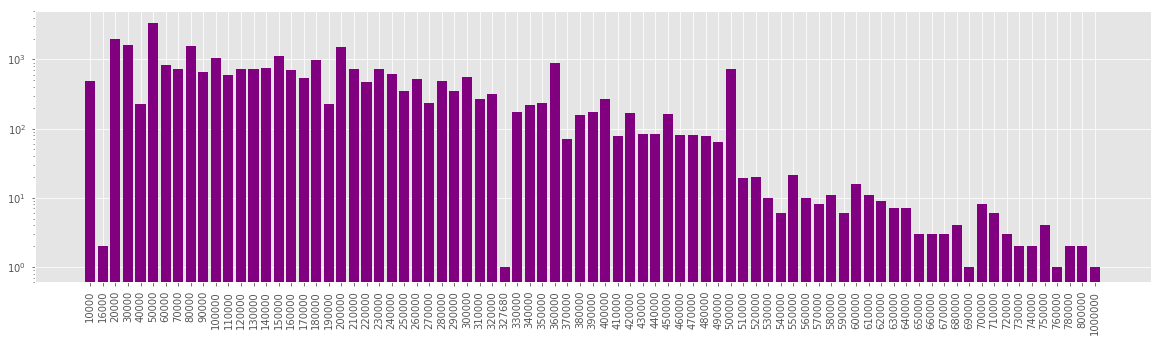

In [15]:
# limit balance
fig = plt.figure()
fig.set_size_inches(20,5)
ax = fig.add_subplot(111)

d = df.groupby(['limit_bal']).size()
ax.set_yscale("log")
ax.set_xticks(np.arange(len(d)))
ax.set_xticklabels(['%d' % i for i in d.index], rotation='vertical')
p = ax.bar(np.arange(len(d)), d, color='purple')

#### Explore Defaulting

First off, let's start with a zoomed out view on the problem.  
We want to predict defaulting, Let's answer the following questions:

  - how many cases do we have on our dataset to work with? 
  - What is the breakdown depending on some of the variables available?

defaulting accounts are 22.12% out of 30000 observations


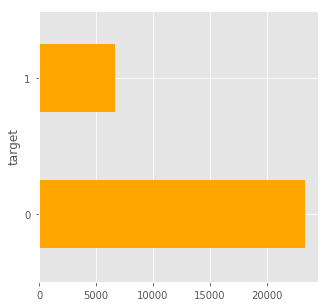

In [16]:
fig = plt.figure()
fig.set_size_inches(5,5)
d = df.groupby(['target']).size()

print("defaulting accounts are {}% out of {} observations".format(100* d[1]/(d[1]+d[0]), d[1]+d[0]))
p = d.plot(kind='barh', color='orange')


#### Explore some statistics of defaulting using the categorical variables

Let's have a look at a number of histograms to see how defaulting correlated with the categorical variables available, before that let's make use of categorical features of pandas, by converting target, sex, marriage, education, age and the pay_\* columns to categories

In [17]:
df['sex'] = df['sex'].astype('category').cat.rename_categories(['M', 'F'])
df['marriage'] = df['marriage'].astype('category').cat.rename_categories(['na', 'married', 'single', 'other'])


In [18]:
df['age_cat'] = pd.cut(df['age'], range(0, 100, 10), right=False)

In [19]:
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]
for i in pay_status_columns:
    df[i] = df[i].astype('category')

### Absolute statistics

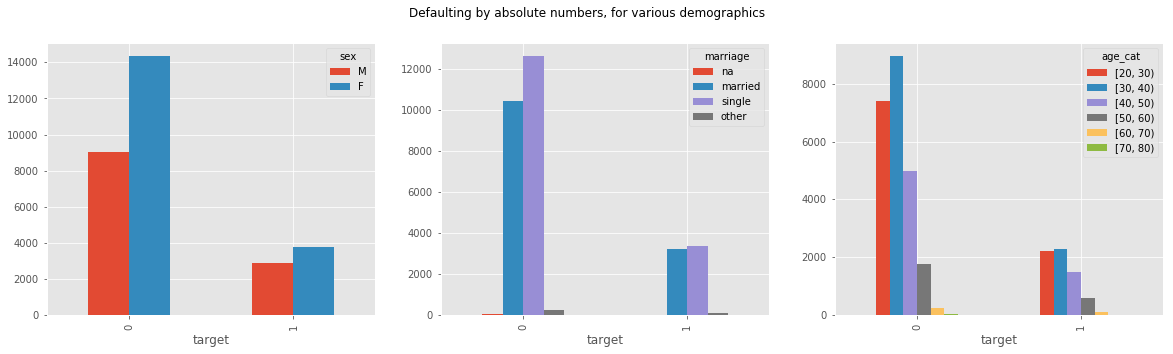

In [20]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)
fig.suptitle('Defaulting by absolute numbers, for various demographics')

d = df.groupby(['target', 'sex']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[0])

d = df.groupby(['target', 'marriage']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[1])

d = df.groupby(['target', 'age_cat']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[2])

#### Statistics relative to the population

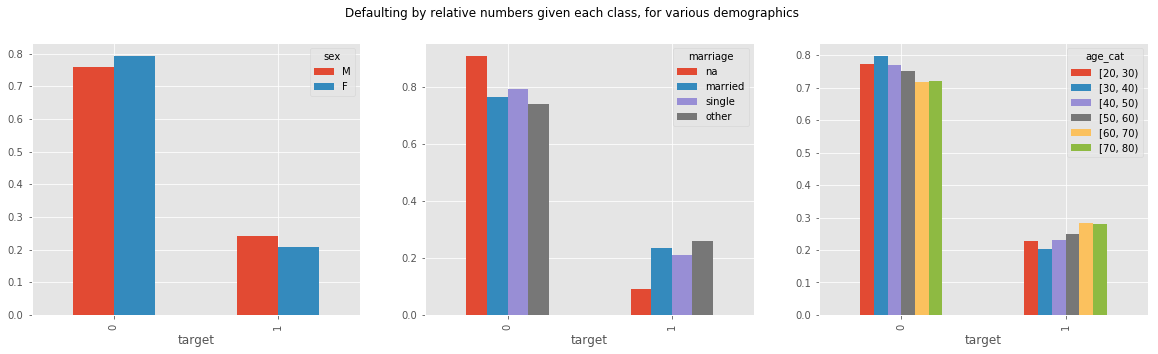

In [21]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)
fig.suptitle('Defaulting by relative numbers given each class, for various demographics')

d = df.groupby(['target', 'sex']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[0])

d = df.groupby(['target', 'marriage']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[1])

d = df.groupby(['target', 'age_cat']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[2])

### Feature engineering

It's not about blind feature conversion to values between 0 and 1, it's about understanding data. In this case we see that payment they exibits a log/log distribution, so first off, we are going to take the log of the payments.

In [22]:
# help func
def selcols(prefix, a=1, b=6):
    return [prefix+str(i) for i in np.arange(a,b+1)]

In [23]:
from math import log

# average and standard deviation payment status
df['pay_avg'] = df[selcols('pay_')].mean(axis=1)
df['pay_std'] = df[selcols('pay_')].std(axis=1)

In [24]:
# average payment
df['pay_amt_avg']     = df[selcols('pay_amt')].mean(axis=1)

# log of average
df['pay_amt_avg_log'] = df['pay_amt_avg'].apply(lambda x: log(x+1))

#amounts relative to the average payment
for i in np.arange(1,7):
    df['pay_relamt'+str(i)] = df['pay_amt'+str(i)]/df['pay_amt_avg']

# log of payments
for i in np.arange(1,7):
    df['pay_amt_log'+str(i)] = df['pay_amt'+str(i)].apply(lambda x: log(x+1))

In [25]:
# average bill
df['bill_amt_avg'] = df[selcols('bill_amt')].mean(axis=1)
df['bill_amt_avg_log'] = df['bill_amt_avg'].apply(lambda x: log(x+1) if x>0 else 0)

# bill sign as a separate feature
for i in np.arange(1,7):
    df['bill_amt_sign'+str(i)] = df['bill_amt'+str(i)].apply(lambda x: float(x>0))
    
# bill log as a separate feature (0 if bill is negative)
for i in np.arange(1,7):
    df['bill_amt_log'+str(i)] = df['bill_amt'+str(i)].apply(lambda x: log(x+1) if x>0 else 0)
    
#bill amounts relative to the limit
for i in np.arange(1,7):
    df['bill_relamt'+str(i)] = df['bill_amt'+str(i)]/df['limit_bal']


In [26]:
#log of credit limit
df['limit_bal_log'] = df['limit_bal'].apply(lambda x: log(x+1))
df['limit_bal_cat'] = pd.cut(df['limit_bal'], range(0, int(1e6), 10000), right=False)

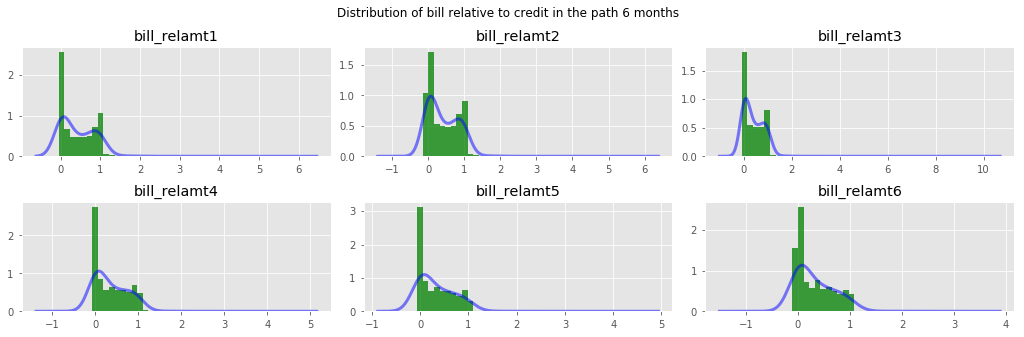

In [27]:
from sklearn.neighbors.kde import KernelDensity

pattern = re.compile("^bill_relamt[0-9]+$")
columns = [ x for x in df.columns if (pattern.match(x))]

fig, ax = plt.subplots(2,3)
fig.set_size_inches(15,5)
fig.suptitle('Distribution of bill relative to credit in the path 6 months')

for i in range(len(columns)):
    row,col = int(i/3), i%3

    d = df[columns[i]]
    # the histogram of the data
    n, bins, patches = ax[row,col].hist(d, 50, normed=1, facecolor='green', alpha=0.75)

    # kernel density estimation
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(d.values.reshape(-1, 1))
    x_grid = np.linspace(d.min(), d.max(), 1000)
    log_pdf = kde.score_samples(x_grid.reshape(-1, 1))

    # add the density line
    ax[row,col].plot(x_grid, np.exp(log_pdf), color='blue', alpha=0.5, lw=3)
    ax[row,col].set_title(columns[i])

plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
plt.show()

Intuition: if the credit is much larger than the bill, being behind might not be a problem. Therefore this contructed feature mightturn up useful when predicting defaulting

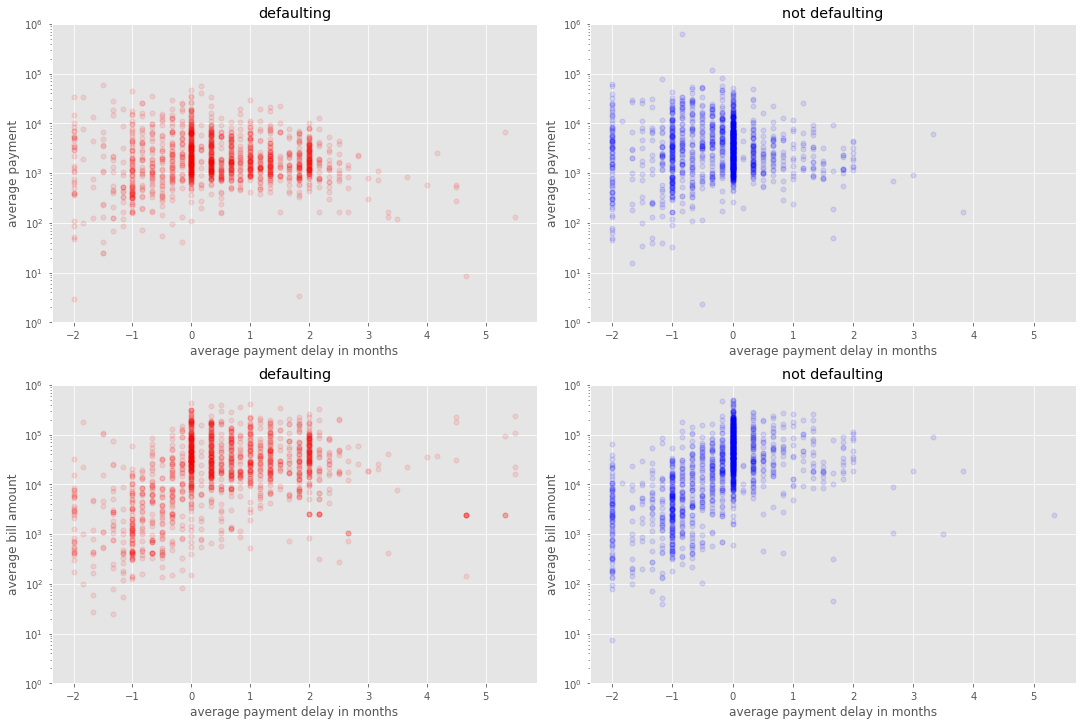

In [28]:
def_no = df[df['target']==0].sample(1500)
def_yes  = df[df['target']==1].sample(1500)

fig,ax = plt.subplots(2,2)
fig.set_size_inches(15,10)

ax[0,0].set_ylim([1,1e6])
ax[0,0].set_title('defaulting')
ax[0,0].set_ylabel('average payment')
ax[0,0].set_xlabel('average payment delay in months')
p = ax[0,0].semilogy(def_yes['pay_avg'], def_yes['pay_amt_avg'], 'ro', markersize=5, alpha=0.1)

ax[0,1].set_ylim([1,1e6])
ax[0,1].set_title('not defaulting')
ax[0,1].set_ylabel('average payment')
ax[0,1].set_xlabel('average payment delay in months')
p = ax[0,1].semilogy(def_no['pay_avg'], def_no['pay_amt_avg'], 'bo', markersize=5, alpha=0.1)

ax[1,0].set_ylim([1,1e6])
ax[1,0].set_title('defaulting')
ax[1,0].set_ylabel('average bill amount')
ax[1,0].set_xlabel('average payment delay in months')
p = ax[1,0].semilogy(def_yes['pay_avg'], def_yes['bill_amt_avg'], 'ro', markersize=5, alpha=0.1)

ax[1,1].set_ylim([1,1e6])
ax[1,1].set_title('not defaulting')
ax[1,1].set_ylabel('average bill amount')
ax[1,1].set_xlabel('average payment delay in months')
p = ax[1,1].semilogy(def_no['pay_avg'], def_no['bill_amt_avg'], 'bo', markersize=5, alpha=0.1)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

#### From variables to train, test matrices

In [29]:
from patsy import dmatrices

formula  = 'target ~ '

# original features
formula += 'C(sex) + C(marriage) +  C(education) + age'
formula += '+' + '+'.join(selcols('pay_'))

#### engineered / normalized features

# categorical age and credit limit (binned)
formula += '+' + 'C(age_cat)'
formula += '+' + 'C(limit_bal_cat) + limit_bal_log'

#pay delays
formula += '+' + 'pay_avg + pay_std'
    
#pay_amt
formula += '+' + 'pay_amt_avg_log'
formula += '+' + '+'.join(selcols('pay_relamt'))
formula += '+' + '+'.join(selcols('pay_amt_log'))

# bill amounts
formula += '+' + 'bill_amt_avg_log'
formula += '+' + '+'.join(selcols('bill_relamt'))
formula += '+' + '+'.join(selcols('bill_amt_sign'))
formula += '+' + '+'.join(selcols('bill_amt_log'))

y, X = dmatrices(formula, data=df, return_type='dataframe')
y = y.iloc[:, 1]

#### Visualization: Confusion matrices and AUC curves

In [30]:
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix

def plot_cm(ax, y_true, y_pred, classes, title, th=0.5, cmap=plt.cm.Blues):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def plot_auc(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):

    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    acc_train = accuracy_score(y_train, y_train_pred_labels)

    fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    acc_test = accuracy_score(y_test, y_test_pred_labels)

    ax.plot(fpr_train, tpr_train)
    ax.plot(fpr_test, tpr_test)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    
    train_text = 'train acc = {:.3f}, auc = {:.2f}'.format(acc_train, roc_auc_train)
    test_text = 'test acc = {:.3f}, auc = {:.2f}'.format(acc_test, roc_auc_test)
    ax.legend([train_text, test_text])


#### Feature selection



In [31]:
import warnings
from sklearn.feature_selection import SelectKBest, f_classif

warnings.simplefilter(action='ignore', category=(UserWarning,RuntimeWarning))

selector = SelectKBest(f_classif, 25)
selector.fit(X, y)

SelectKBest(k=25, score_func=<function f_classif at 0x10eba27b8>)

In [32]:
top_indices = np.nan_to_num(selector.scores_).argsort()[-25:][::-1]
selector.scores_[top_indices]
X.columns[top_indices]

Index(['pay_1[T.2]', 'pay_2[T.2]', 'pay_avg', 'pay_3[T.2]', 'pay_4[T.2]',
       'pay_5[T.2]', 'pay_std', 'pay_6[T.2]', 'pay_1[T.0]', 'limit_bal_log',
       'pay_amt_log1', 'pay_amt_avg_log', 'bill_relamt6', 'pay_2[T.0]',
       'bill_relamt5', 'bill_relamt4', 'pay_amt_log2', 'bill_relamt3',
       'bill_relamt2', 'pay_amt_log3', 'pay_1[T.3]', 'bill_relamt1',
       'pay_2[T.3]', 'pay_3[T.0]', 'pay_amt_log4'],
      dtype='object')

Remarks: Looks like some of the constructed features are indeed beneficial.
Also it seems that demographics are only marginally influencing the prediction.
paid amounts, delays, and bill relative to credit issued are top indicators. Interestingly education score quite high as a a predictive feature.

#### Feature scaling



In [33]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
scaler.fit(X)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [34]:
from sklearn.pipeline import Pipeline

preprocess = Pipeline([('anova', selector), ('scale', scaler)])
preprocess.fit(X,y)

X_prep = preprocess.transform(X)

#### Model selection and validation

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size=0.2, random_state=42)

### Models
#### Logistic regression (baseline models)

In [36]:
from sklearn import linear_model

# Create logistic regression object
regr = linear_model.LogisticRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

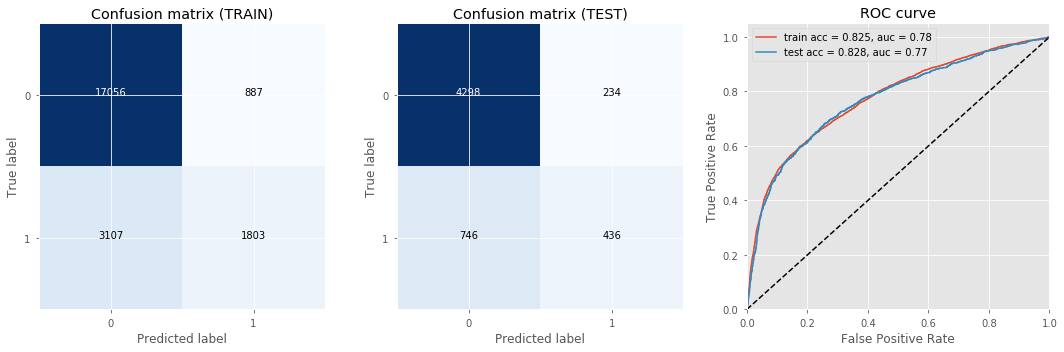

In [37]:
y_train_pred = regr.predict_proba(X_train)[:,1]
y_test_pred = regr.predict_proba(X_test)[:,1]

threshold = 0.5

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

#### Random Forest 
Quite popular a few years back, bootstrap aggregating ensamble of decision trees

In [38]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, min_samples_leaf=5)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

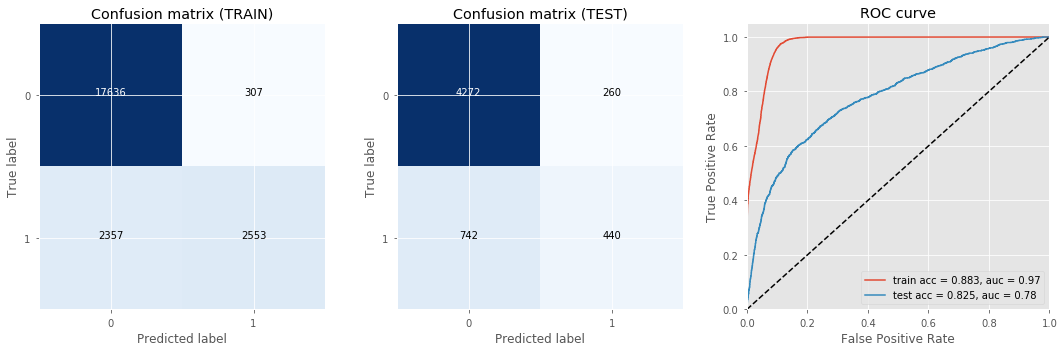

In [39]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score

threshold = 0.5
y_train_pred = rf.predict_proba(X_train)[:,1]
y_test_pred = rf.predict_proba(X_test)[:,1]

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

#### Decision Trees boosting

An iterative model for refining a model by looking at the remainder error.

In [40]:
import xgboost as xgb

In [41]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [42]:
num_round = 5
evallist  = [(dtest,'eval'), (dtrain,'train')]
param = {'objective':'binary:logistic', 'silent':1, 'eval_metric': ['error', 'logloss']}

bst = xgb.train( param, dtrain, num_round, evallist )

[0]	eval-error:0.178159	eval-logloss:0.572755	train-error:0.167505	train-logloss:0.56884
[1]	eval-error:0.178509	eval-logloss:0.508294	train-error:0.165624	train-logloss:0.501547
[2]	eval-error:0.176234	eval-logloss:0.471332	train-error:0.165011	train-logloss:0.461777
[3]	eval-error:0.175884	eval-logloss:0.449392	train-error:0.164617	train-logloss:0.437175
[4]	eval-error:0.175359	eval-logloss:0.435512	train-error:0.162998	train-logloss:0.421063


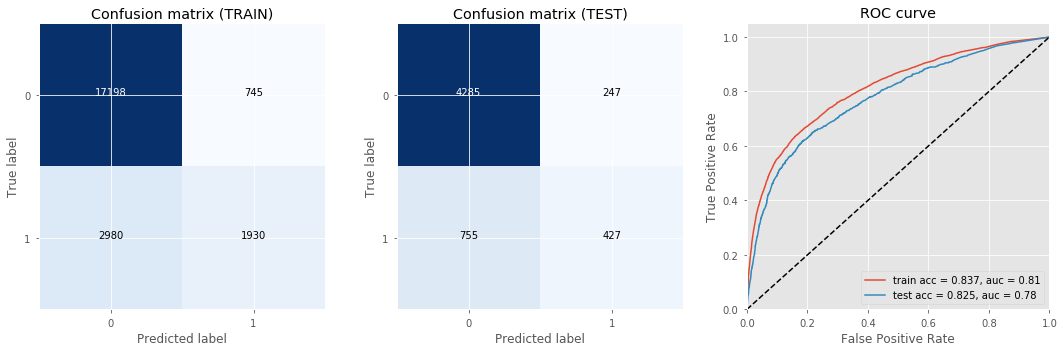

In [43]:
threshold = 0.5
y_train_pred = bst.predict(dtrain)
y_test_pred = bst.predict(dtest)

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

#### Feed forward deep neural nets

In [61]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

In [62]:
input_dim = X_train.shape[1]

model = Sequential()
model.add(Dense(256, input_shape=(input_dim,), activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(1,  activation='sigmoid'))

In [63]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [64]:
from keras.callbacks import Callback

class BatchLogger(Callback):
    def on_train_begin(self, epoch, logs={}):
        self.log_values = {}
        for k in self.params['metrics']:
            self.log_values[k] = []

    def on_epoch_end(self, batch, logs={}):
        for k in self.params['metrics']:
            if k in logs:
                self.log_values[k].append(logs[k])
    
    def get_values(self, metric_name, window):
        d =  pd.Series(self.log_values[metric_name])
        return d.rolling(window,center=False).mean()

bl = BatchLogger()

In [65]:
history = model.fit(
              np.array(X_train), np.array(y_train),
              batch_size=25, epochs=5, verbose=1, callbacks=[bl],
              validation_data=(np.array(X_test), np.array(y_test)))

Train on 22853 samples, validate on 5714 samples
Epoch 1/5
22853/22853 [==============================] - 4s - loss: 0.4441 - acc: 0.8171 - val_loss: 0.4240 - val_acc: 0.8276
Epoch 2/5
22853/22853 [==============================] - 4s - loss: 0.4282 - acc: 0.8261 - val_loss: 0.4203 - val_acc: 0.8281
Epoch 3/5
22853/22853 [==============================] - 4s - loss: 0.4259 - acc: 0.8270 - val_loss: 0.4195 - val_acc: 0.8299
Epoch 4/5
22853/22853 [==============================] - 4s - loss: 0.4252 - acc: 0.8269 - val_loss: 0.4213 - val_acc: 0.8281
Epoch 5/5
22853/22853 [==============================] - 4s - loss: 0.4231 - acc: 0.8290 - val_loss: 0.4226 - val_acc: 0.8292


In [66]:
score = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
print('Test log loss:', score[0])
print('Test accuracy:', score[1])

Test log loss: 0.422555228026
Test accuracy: 0.82919145951


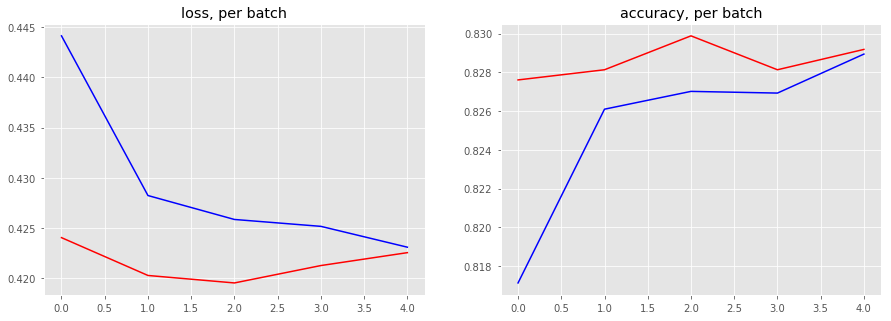

In [67]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.title('loss, per batch')
plt.plot(bl.get_values('loss',1), 'b-', label='train');
plt.plot(bl.get_values('val_loss',1), 'r-', label='test');

plt.subplot(1, 2, 2)
plt.title('accuracy, per batch')
plt.plot(bl.get_values('acc',1), 'b-', label='train');
plt.plot(bl.get_values('val_acc',1), 'r-', label='test');
plt.show()

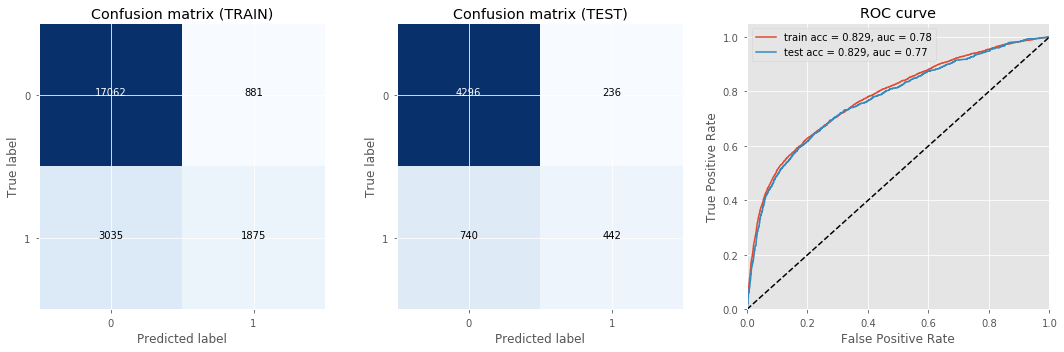

In [68]:
y_train_pred = model.predict_on_batch(np.array(X_train))[:,0]
y_test_pred = model.predict_on_batch(np.array(X_test))[:,0]

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0], y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)')
plot_cm(ax[1], y_test, y_test_pred, [0,1], 'Confusion matrix (TEST)')

plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred)
    
plt.tight_layout()
plt.show()

#### Peeking in the "brain" of our neural network

In [69]:
# we build a new model with the activations of the old model
# this model is truncated before the last layer

model2 = Sequential()
model2.add(Dense(256, input_shape=(input_dim,), activation='relu', weights=model.layers[0].get_weights()))
model2.add(Dense(256, activation='relu', weights=model.layers[1].get_weights()))
model2.add(Dense(64, activation='relu', weights=model.layers[2].get_weights()))
model2.add(Dense(64, activation='relu', weights=model.layers[3].get_weights()))
model2.add(Dense(10, activation='sigmoid', weights=model.layers[4].get_weights()))


In [70]:
activations = model2.predict_on_batch(np.array(X_test))

#### "Picking the brain" (method 1):  TSNE analysis

In [71]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=25, verbose=0, n_iter=500, random_state=1337)
samples = tsne.fit_transform(activations)

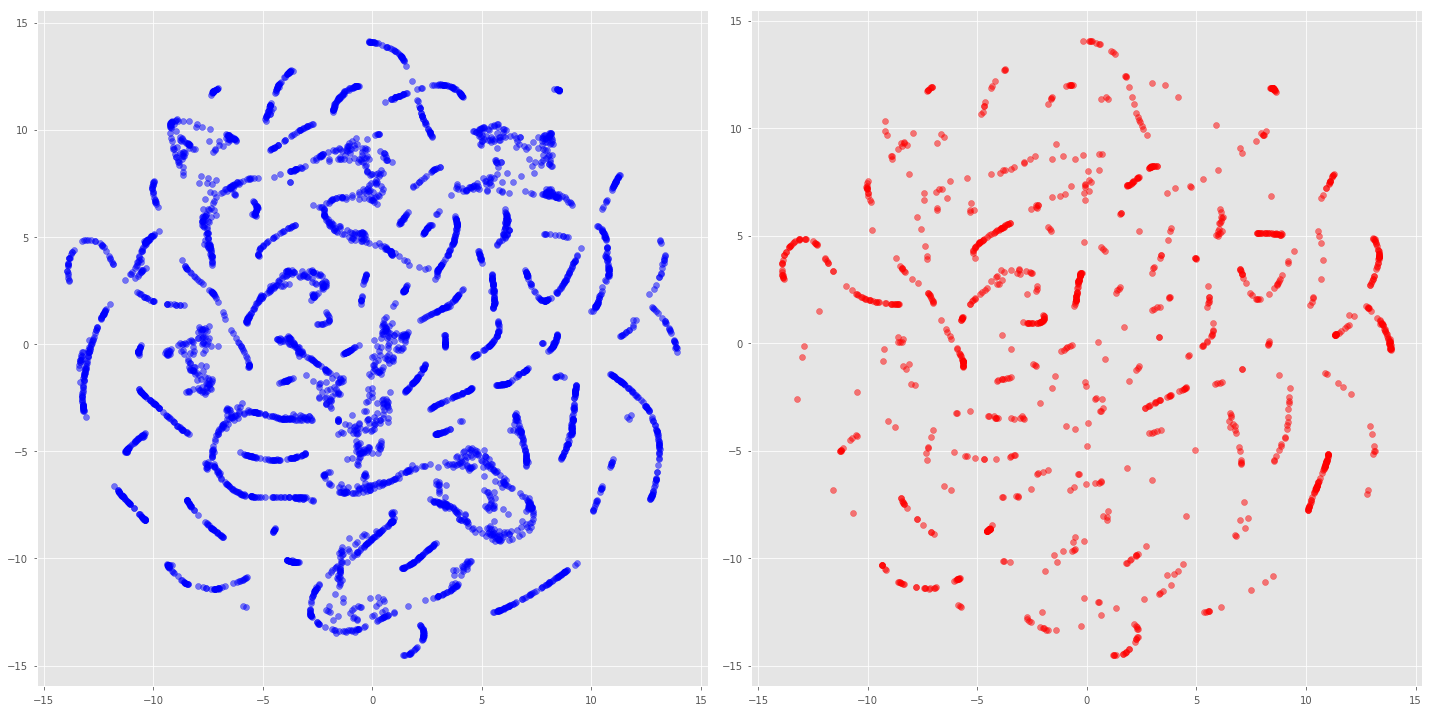

In [72]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].scatter(*samples[y_test==0].T,color='b', alpha=0.5, label='default: NO')
ax[1].scatter(*samples[y_test==1].T,color='r', alpha=0.5, label='default: YES')

plt.tight_layout()
plt.show()

In [ ]:
# cluster and show the lift curve for that particular segment
# percent of defaulting in that specific cluster
# histogram of the the top caracterizing functions with that

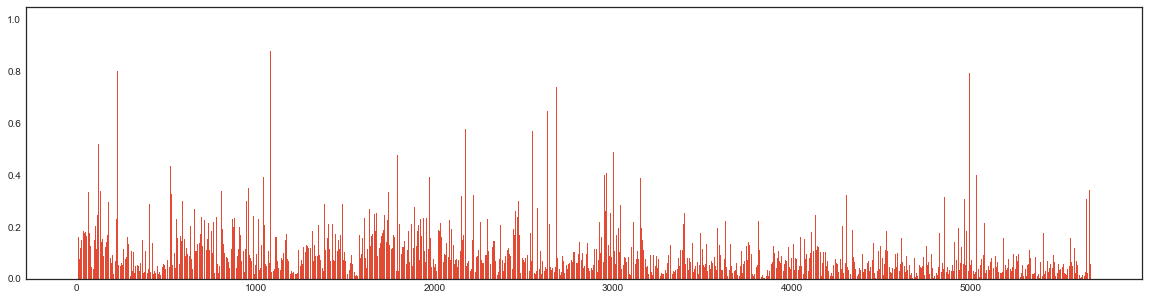

In [308]:
from pyclustering.cluster.optics import optics

# Create OPTICS algorithm for cluster analysis
optics_instance = optics(samples, 1, 3, 100);

# Run cluster analysis
optics_instance.process();
 
# Obtain results of clustering
clusters = optics_instance.get_clusters();
noise = optics_instance.get_noise();

# Obtain rechability-distances
ordering = optics_instance.get_ordering();

# Visualization of cluster ordering in line with reachability distance.
indexes = [i for i in range(0, len(ordering))];

fig = plt.figure()
fig.set_size_inches(20,5)
plt.bar(indexes, ordering);
plt.show(); 

In [501]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

pred  = (y_test_pred>0.5).astype(int)
truth = (y_test>0.5).values.astype(int)

avg = y_test.mean()

cluster_defaulting_data = [ 
    [ 
        len(cl) , 
        truth[cl].mean(), 
        pred[cl].mean(),
        max(np.bincount(truth[cl])/len(truth[cl])),
        max(np.bincount(pred[cl])/len(pred[cl])),
        truth[cl].mean()/avg,
        pred[cl].mean()/avg,
        accuracy_score(truth[cl], pred[cl]),
        f1_score(truth[cl], pred[cl]),
        precision_score(truth[cl], pred[cl]),
        recall_score(truth[cl], pred[cl])
    ] for cl in clusters ]

columns=[
    'count', 
    'rate_truth', 
    'rate_pred', 
    'purity_truth', 
    'purity_pred', 
    'lift_truth', 
    'lift_pred', 
    'accuracy', 
    'f1', 
    'precision', 
    'recall']

cl_df = pd.DataFrame(cluster_defaulting_data, columns=columns)

In [502]:
cl_df.shape

(127, 11)

In [519]:
# check which have the best F1 score
sel = ((cl_df['f1']>0.7) | (cl_df['accuracy']>0.82))
clusters_topsel = cl_df[sel]
clusters_topsel.head(10)

,count,rate_truth,rate_pred,purity_truth,purity_pred,lift_truth,lift_pred,accuracy,f1,precision,recall
0,52,0.019231,0.0,0.980769,1.0,0.092965,0.0,0.980769,0.0,0.0,0.0
1,53,0.113208,0.0,0.886792,1.0,0.547266,0.0,0.886792,0.0,0.0,0.0
2,93,0.032258,0.0,0.967742,1.0,0.155941,0.0,0.967742,0.0,0.0,0.0
3,45,0.088889,0.0,0.911111,1.0,0.429705,0.0,0.911111,0.0,0.0,0.0
5,38,0.078947,0.0,0.921053,1.0,0.381646,0.0,0.921053,0.0,0.0,0.0
7,62,0.064516,0.0,0.935484,1.0,0.311883,0.0,0.935484,0.0,0.0,0.0
8,57,0.175439,0.0,0.824561,1.0,0.848102,0.0,0.824561,0.0,0.0,0.0
10,55,0.127273,0.0,0.872727,1.0,0.615259,0.0,0.872727,0.0,0.0,0.0
11,36,0.083333,0.0,0.916667,1.0,0.402848,0.0,0.916667,0.0,0.0,0.0
12,150,0.166667,0.0,0.833333,1.0,0.805697,0.0,0.833333,0.0,0.0,0.0


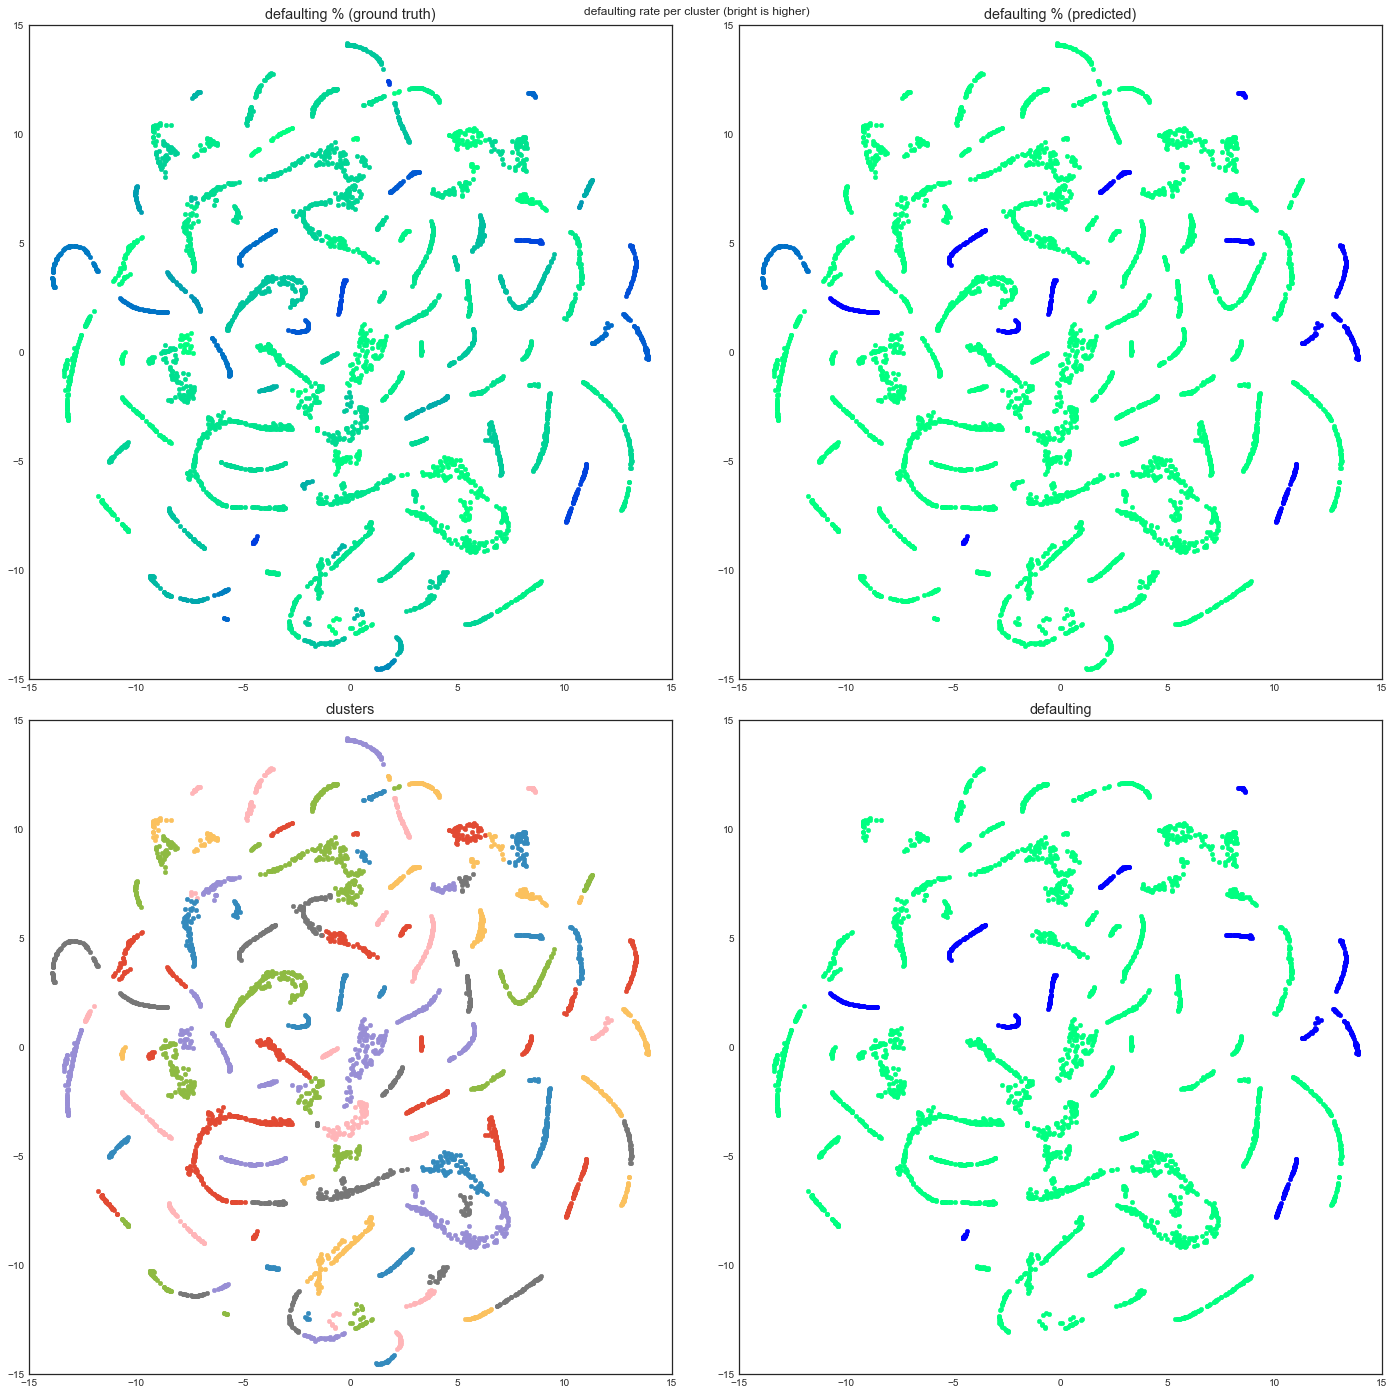

In [520]:
# prepare figure
fig,ax = plt.subplots(2,2)
fig.set_size_inches(20,20)

cmap = plt.cm.winter_r
color_true = cl_df['rate_truth'].apply(cmap)
color_pred = cl_df['rate_pred'].apply(cmap)

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_xlim([-15, 15])
        ax[i,j].set_ylim([-15, 15])

for i in range(len(clusters)):
    d = samples[clusters[i],:]
    
    ax[0,0].scatter(d[:,0], d[:,1], s=20, color=color_true[i])
    ax[0,1].scatter(d[:,0], d[:,1], s=20, color=color_pred[i])

    ax[1,0].scatter(d[:,0], d[:,1], s=20)
    if i in clusters_topsel.index:
        ax[1,1].scatter(d[:,0], d[:,1], s=20, color=color_pred[i])

fig.suptitle("defaulting rate per cluster (bright is higher)")

ax[0,0].set_title("defaulting % (ground truth)")
ax[0,1].set_title("defaulting % (predicted)")

ax[1,0].set_title('clusters')
ax[1,1].set_title('defaulting')

plt.tight_layout(pad=3, w_pad=4, h_pad=1.0)
plt.show()

#### Peeking on the brain :  TDA analysis on TSNE lens

In [521]:
import importlib
importlib.reload(km)

<module 'km' from '/Users/natalino/Projects/deepcredit/km.py'>

In [523]:
# Import the class
import km

# Initialize
mapper = km.KeplerMapper(verbose=1)

# Fit to and transform the data
projected_data = mapper.fit_transform(samples, projection=[0,1]) #list(range(activations.shape[1])))

projected_data.shape

Projecting data using: [0, 1]
Scaling with: MinMaxScaler(copy=True, feature_range=(0, 1))


(5714, 2)

In [531]:
# Create dictionary called 'complex' with nodes, edges and meta-information
complex = mapper.map(projected_data, activations, nr_cubes=20,clusterer=tda.cluster.DBSCAN(eps=0.01, min_samples=10), overlap_perc=0.5)

Mapping on data shaped (5714, 2) using dimensions
Creating 400 hypercubes.
Created 501 edges and 334 nodes in 0:00:04.936227.


In [532]:
# Visualize it
mapper.visualize(complex, path_html="output.html", show_title=False, 
                 show_meta=False, bg_color_css="#FFF", graph_gravity=0.4)

from IPython.display import IFrame
IFrame('output.html', width='100%', height=700)

Wrote d3.js graph to 'output.html'
